In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johnd\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
# Load the dataset
file_path = 'SMSSpamCollection'  # Adjust the path to your .txt file
df = pd.read_csv(file_path, sep='\t', header=None, names=['label', 'message'])

# Display the first few rows
print(df.head())

# Optionally: Check the distribution of labels
print(df['label'].value_counts())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
ham     4825
spam     747
Name: label, dtype: int64


# Data preprocessing

We will eliminate common words (stopwords) that do not contribute significantly to the meaning of the text.

In [5]:
# Data preprocessing
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# text preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Applying preprocessing to the message column
df['message'] = df['message'].apply(preprocess_text)

Utilising TfidfVectorizer to convert the text messages into numerical representations.

In [6]:
df['message'] = df['message'].apply(preprocess_text)

# Now proceed with vectorization
X = df['message']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Model Selection

In [7]:
# Build and train SVC model
model = SVC(probability=True)  # probability=True to get probabilities
model.fit(X_train_tfidf, y_train)

SVC(probability=True)

Model evaluation

In [8]:
# Evaluate model
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

[[966   0]
 [ 23 126]]


Performance visualization

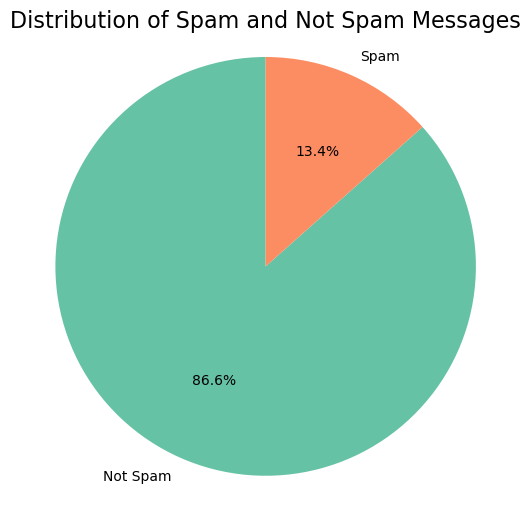

In [9]:
# Visualization of the dataset distribution
plt.figure(figsize=(6, 6))
labels = df['label'].value_counts().index.map({0: 'Not Spam', 1: 'Spam'})
sizes = df['label'].value_counts().values

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title('Distribution of Spam and Not Spam Messages', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular
plt.show()

We observe through data visualization and exploration that about 86.6% of our data is legitimate(not spam) while the remaining 13.4% is spam

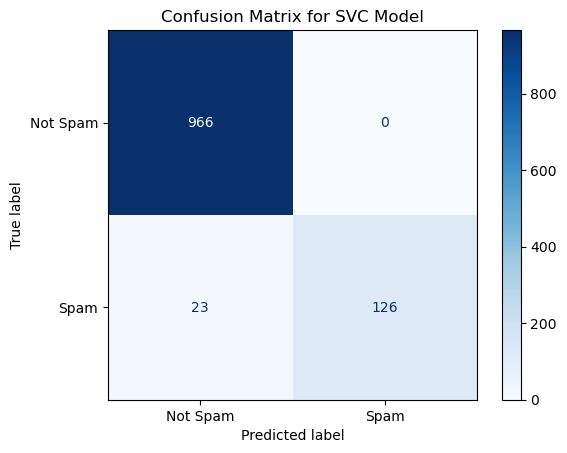

In [10]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Spam', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVC Model')
plt.show()

**Summary of the Confusion matrix :**

True Negatives (TN): 966 (Correctly predicted as "Not Spam")

False Positives (FP): 0 (Incorrectly predicted as "Spam")

False Negatives (FN): 23 (Incorrectly predicted as "Not Spam")

True Positives (TP): 126 (Correctly predicted as "Spam")

In [11]:
# Collect and visualize model performance metrics
model_metrics = {
    "SVC": accuracy_score(y_test, y_pred)
}

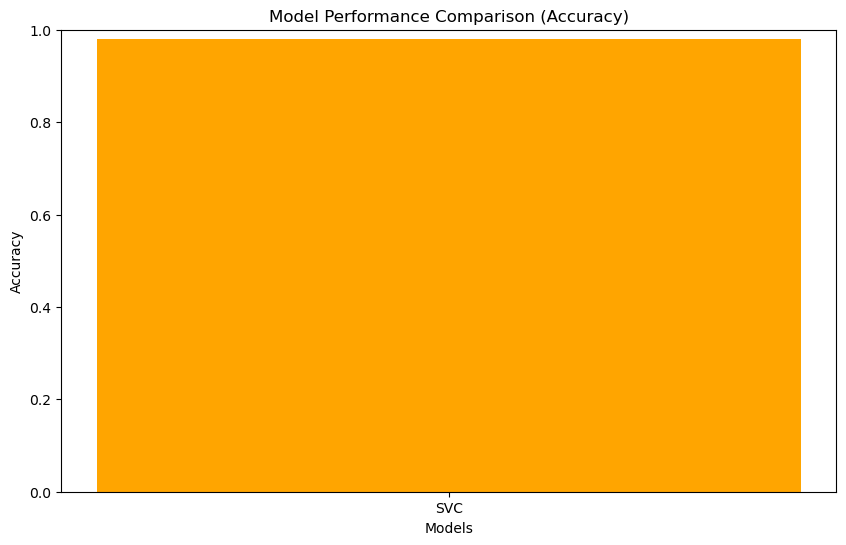

In [12]:
# Plotting model performance
plt.figure(figsize=(10, 6))
plt.bar(model_metrics.keys(), model_metrics.values(), color=['orange'])
plt.title('Model Performance Comparison (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.ylim(0, 1)  # Set y-axis from 0 to 1
plt.show()

In [13]:
# Function to classify new messages
def classify_new_messages(messages, model):
    # Transform new messages using the same TF-IDF vectorizer
    messages_tfidf = tfidf.transform(messages)
    predictions = model.predict(messages_tfidf)
    probabilities = model.predict_proba(messages_tfidf)

    results = pd.DataFrame({
        'Message': messages,
        'Prediction': ['Spam' if pred == 1 else 'Not Spam' for pred in predictions],
        'Probability of Spam': probabilities[:, 1]
    })
    return results

# Example of new messages to classify
new_messages = [
    "Congratulations! You've won a $1000 cash prize. Call now!",
    "Hello, how are you doing today?",
    "Get a free trial of our product!",
    "Looking forward to our meeting tomorrow."
]

# Using SVC model for classification
classified_results = classify_new_messages(new_messages, model)
print(classified_results)

                                             Message Prediction  \
0  Congratulations! You've won a $1000 cash prize...       Spam   
1                    Hello, how are you doing today?   Not Spam   
2                   Get a free trial of our product!   Not Spam   
3           Looking forward to our meeting tomorrow.   Not Spam   

   Probability of Spam  
0             1.000000  
1             0.002617  
2             0.588935  
3             0.002465  


# Summary
The model achieves an accuracy of 98%. This value indicates a high level of correct predictions overall, but while the model performs well, there are still 23 instances of false negatives (spam messages incorrectly classified as not spam).

The SVC model performs well in classifying SMS messages into 'spam' and 'not spam', achieving high precision and recall across the board. While the recall for 'spam' could benefit from improvement—given a small number of false negatives—the overall capabilities of the model in real-world applications appear robust, making it a viable choice for spam detection.

To further enhance model performance, we could consider exploring techniques like hyperparameter tuning, balanced datasets, or incorporating additional features, which may help to reduce false negatives for spam classification even further.